In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob, os
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization,Activation,LeakyReLU,Conv2D,MaxPooling2D,AveragePooling2D,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical
from keras.utils import plot_model

In [2]:
filepath = './imgAug/'
imgList = glob.glob(filepath+"*")
yearLabel = {'9': 0,
             '0': 1,
             '1': 2}

imgdata = []
eraLabel = []

for path_ in imgList:
    img = Image.open(path_)

    # RGB 일 때
    img = np.array(img).reshape(-1)
    if len(img) == 6912:
        imgdata.append(img)

        era = path_.split('/')[-1].split('_')[1][2]
        eraLabel.append(yearLabel[era])

imgdata = np.array(imgdata).reshape((-1,48,48,3))
eraLabel = np.array(eraLabel)

In [3]:
np.unique(eraLabel)

array([0, 1, 2])

In [4]:
imgdata.shape, eraLabel.shape

((11748, 48, 48, 3), (11748,))

In [5]:
# 정규화 및 원핫인코딩
imgdata = imgdata.astype('float32')/255.0
eraLabel = to_categorical(eraLabel).astype(int)

# 모델 생성
folderpath = './models/'
if not os.path.exists(folderpath):
    os.makedirs(folderpath)
    print('models 폴더 생성 완료')

folderpath1 = './image/'
if not os.path.exists(folderpath1):
    os.makedirs(folderpath1)
    print('image 폴더 생성 완료')

In [7]:
def plotScore(history, name):
    # 검증셋과 학습셋의 오차를 저장
    y_vAcc = history.history['val_accuracy']
    y_Acc = history.history['accuracy']

    # 그래프로 표현해 봅니다
    x_len = np.arange(len(y_Acc))
    plt.plot(x_len,y_vAcc,marker='.',c='red',label='Test_acc')
    plt.plot(x_len,y_Acc,marker='.',c='blue',label='Train_acc')

    # 그래프에 그리드를 주고 레이블 표시
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.savefig(f'./image/{name}_acc.jpg')
    plt.show()


    # 검증셋과 학습셋의 오차를 저장
    y_vloss = history.history['val_loss']
    y_loss = history.history['loss']

    # 그래프로 표현해 봅니다
    x_len = np.arange(len(y_Acc))
    plt.plot(x_len,y_vloss,marker='.',c='red',label='Test_loss')
    plt.plot(x_len,y_loss,marker='.',c='blue',label='Train_loss')

    # 그래프에 그리드를 주고 레이블 표시
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(f'./image/{name}_loss.jpg')
    plt.show()

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.1351 - accuracy: 0.4382
Epoch 1: val_accuracy improved from -inf to 0.40383, saving model to ./models/ResNet50_Dense1_regular_batch128_epoch50_lr0_01.hdf5
74/74 [==============================] - 28s 360ms/step - loss: 1.1351 - accuracy: 0.4382 - val_loss: 1.1666 - val_accuracy: 0.4038
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.0323 - accuracy: 0.4828
Epoch 2: val_accuracy improved from 0.40383 to 0.42596, saving model to ./models/ResNet50_Dense1_regular_batch128_epoch50_lr0_01.hdf5
74/74 [==============================] - 24s 328ms/step - loss: 1.0323 - accuracy: 0.4828 - val_loss: 1.1437 - val_accuracy: 0.4260
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.5160
Epoch 3: val_accuracy did not improve from 0.42596
74/74 [==============================] - 24s 327ms/step - loss: 0.9825 - accuracy: 0.5160 - val_loss: 1.4472 - val_accuracy: 0.4072
Epoch 

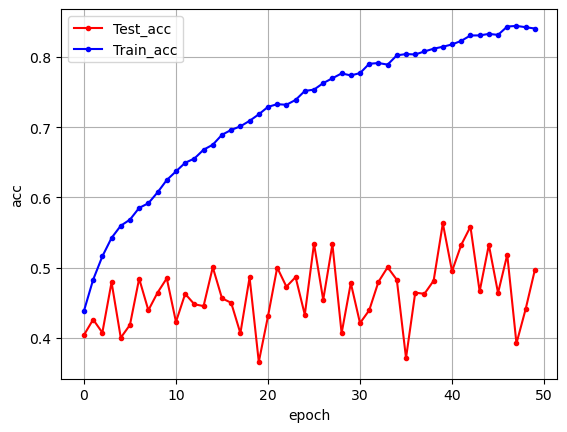

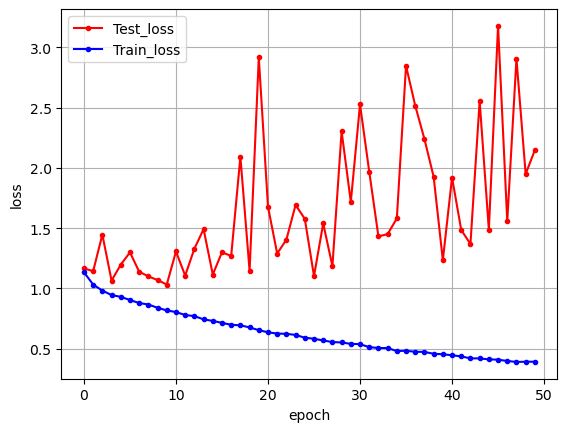

In [8]:
from keras.applications import ResNet50
transfer_model = ResNet50(weights='imagenet',include_top=False, input_shape=(48,48,3))
transfer_model.trainable = False

finietune_model = Sequential(name='ResNet50_Dense1_regular_batch256_epoch50_lr0_01')
finietune_model.add(transfer_model)
finietune_model.add(Flatten())

finietune_model.add(Dense(64,kernel_initializer='he_normal',kernel_regularizer='L1L2'))
finietune_model.add(BatchNormalization())
finietune_model.add(Activation('relu'))
finietune_model.add(Dropout(0.25))

finietune_model.add(Dense(3,activation='softmax'))

plot_model(finietune_model,to_file=f'{folderpath}{finietune_model.name}.png',show_layer_names=True,show_layer_activations=True,show_shapes=True)

erCB = EarlyStopping(verbose=1,patience=100,monitor='val_accuracy')
mcCB = ModelCheckpoint(folderpath+f"{finietune_model.name}.hdf5",save_best_only=True,monitor='val_accuracy',verbose=1)

def scheduler(epoch,lr=0.05):
    if epoch % 70 == 0:
        return lr * np.math.exp(-0.1)
    else:
        return lr
lrCB = LearningRateScheduler(schedule=scheduler)

finietune_model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy','auc'])

history = finietune_model.fit(imgdata,eraLabel,batch_size=256,epochs=50,
        validation_split=0.2,
        callbacks=[mcCB])




plotScore(history,finietune_model.name)

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.5570
Epoch 1: val_accuracy improved from -inf to 0.47021, saving model to ./models/VGG16_Dense1_regular_batch128_epoch50_lr0_01.hdf5
74/74 [==============================] - 67s 911ms/step - loss: 0.9414 - accuracy: 0.5570 - val_loss: 1.2342 - val_accuracy: 0.4702
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6792
Epoch 2: val_accuracy improved from 0.47021 to 0.51660, saving model to ./models/VGG16_Dense1_regular_batch128_epoch50_lr0_01.hdf5
74/74 [==============================] - 68s 920ms/step - loss: 0.7350 - accuracy: 0.6792 - val_loss: 1.2792 - val_accuracy: 0.5166
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.7540
Epoch 3: val_accuracy improved from 0.51660 to 0.58511, saving model to ./models/VGG16_Dense1_regular_batch128_epoch50_lr0_01.hdf5
74/74 [==============================] - 67s 912ms/step - loss: 

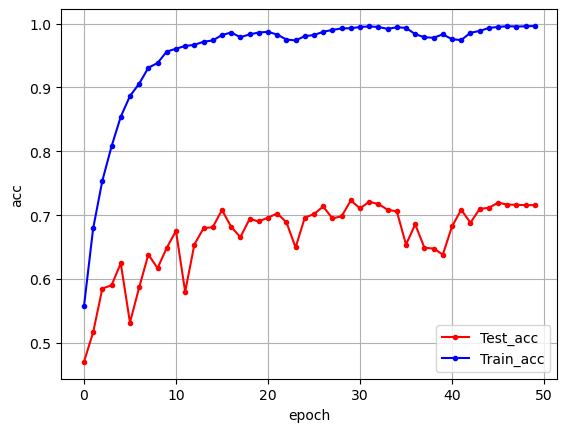

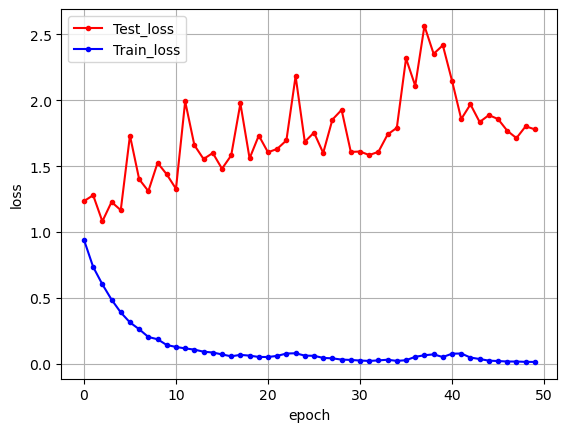

In [9]:
from keras.applications import VGG16
from keras.optimizers import Adam
transfer_model = VGG16(weights='imagenet',include_top=False, input_shape=(48,48,3))
transfer_model.trainable = False

finietune_model = Sequential(name='VGG16_Dense1_regular_batch128_epoch50_lr0_01')
finietune_model.add(transfer_model)
finietune_model.add(Flatten())

finietune_model.add(Dense(64,kernel_initializer='he_normal',kernel_regularizer='L1L2'))
finietune_model.add(BatchNormalization())
finietune_model.add(Activation('relu'))

finietune_model.add(Dense(3,activation='softmax'))

plot_model(finietune_model,to_file=f'{folderpath}{finietune_model.name}.png',show_layer_names=True,show_layer_activations=True,show_shapes=True)

erCB = EarlyStopping(verbose=1,patience=100,monitor='val_accuracy')
mcCB = ModelCheckpoint(folderpath+f"{finietune_model.name}.hdf5",save_best_only=True,monitor='val_accuracy',verbose=1)

def scheduler(epoch,lr):
    if epoch == 200:
        return lr+0.001
    elif epoch == 300:
        return lr+0.001
    else:
      return lr

lrCB = LearningRateScheduler(schedule=scheduler)

from keras.optimizers import Adam
finietune_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01),
            metrics=['accuracy'])

history = finietune_model.fit(imgdata,eraLabel,batch_size=128,epochs=50,
        validation_split=0.2,
        callbacks=[mcCB])




plotScore(history,finietune_model.name)

In [12]:
from keras.applications import VGG19
from keras.optimizers import Adam
transfer_model = VGG19(weights='imagenet',include_top=False, input_shape=(48,48,3))
transfer_model.trainable = False

finietune_model = Sequential(name='VGG19_Dense1_regular_batch256_epoch50_lr0_01')
finietune_model.add(transfer_model)
finietune_model.add(Flatten())

finietune_model.add(Dense(128,kernel_initializer='he_normal',kernel_regularizer='L1L2'))
finietune_model.add(BatchNormalization())
finietune_model.add(Activation('relu'))

finietune_model.add(Dense(3,activation='softmax'))

plot_model(finietune_model,to_file=f'{folderpath}{finietune_model.name}.png',show_layer_names=True,show_layer_activations=True,show_shapes=True)

erCB = EarlyStopping(verbose=1,patience=50,monitor='val_accuracy')
mcCB = ModelCheckpoint(folderpath+f"{finietune_model.name}.hdf5",save_best_only=True,monitor='val_accuracy',verbose=1)

def scheduler(epoch,lr):
    if epoch % 50 == 0:
      return lr - 0.0005
    else:
      return lr
lrCB = LearningRateScheduler(schedule=scheduler)
from keras.optimizers import Adam
finietune_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01),
            metrics=['accuracy'])

history = finietune_model.fit(imgdata,eraLabel,batch_size=256,epochs=50,
        validation_split=0.2,
        callbacks=[mcCB])


plotScore(history,finietune_model.name)

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.5254
Epoch 1: val_accuracy improved from -inf to 0.43191, saving model to ./models/VGG19_Dense1_regular_batch256_epoch50_lr0_01.hdf5
37/37 [==============================] - 71s 2s/step - loss: 1.0296 - accuracy: 0.5254 - val_loss: 1.3077 - val_accuracy: 0.4319
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.7706 - accuracy: 0.6706
Epoch 2: val_accuracy improved from 0.43191 to 0.44851, saving model to ./models/VGG19_Dense1_regular_batch256_epoch50_lr0_01.hdf5
37/37 [==============================] - 82s 2s/step - loss: 0.7706 - accuracy: 0.6706 - val_loss: 1.6143 - val_accuracy: 0.4485
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.7270
Epoch 3: val_accuracy did not improve from 0.44851
37/37 [==============================] - 84s 2s/step - loss: 0.6555 - accuracy: 0.7270 - val_loss: 2.2743 - val_accuracy: 0.3983
Epoch 4/50
37/37 [===

KeyboardInterrupt: 